# 1) Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2) Import libraries

In [ ]:
import numpy as np
import glob
import pandas as pd
import os
import csv
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import zipfile
import shutil

In [ ]:
! pip install ultralytics
! pip install pycocotools
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 11.3 MB/s eta 0:00:00


ModuleNotFoundError: ignored

# 3) Load data

## 3-1) Unzip dataset

In [ ]:
# !kaggle datasets download -d sshikamaru/car-object-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
zip = zipfile.ZipFile('/content/drive/MyDrive/work/1-car object detection/archive.zip')
zip.extractall()

In [ ]:
# from the available data
path="/content/data/"

##3-2) Make directory

In [ ]:
!mkdir '/content/data/data'
!mkdir '/content/data/train_data'
!mkdir '/content/data/train_data/images'
!mkdir '/content/data/train_data/labels'
!mkdir '/content/data/val_data'
!mkdir '/content/data/val_data/images'
!mkdir '/content/data/val_data/labels'

## 3-3) Read data

In [ ]:

df = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')
print(df)

               image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]


#4) Preprocess data

In [ ]:
str_dir='/content/data/training_images/'
width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo['path']=str_dir+df_yolo.img_name
df_yolo.head()

<ipython-input-16-bf1d24b89b6f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yolo['path']=str_dir+df_yolo.img_name


,img_name,class,x_centre,y_centre,width,height,path
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238,/content/data/training_images/vid_4_1000.jpg
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987,/content/data/training_images/vid_4_10000.jpg
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014,/content/data/training_images/vid_4_10040.jpg
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727,/content/data/training_images/vid_4_10020.jpg
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422,/content/data/training_images/vid_4_10060.jpg


#5)split Train and test

In [ ]:
train_data, val_data= train_test_split(df_yolo, test_size=0.3, random_state=42)


train_img = '/content/data/train_data/images'  # Destination directory
file_list = train_data.path.values # Path of the file to add
for file_path in file_list:
    dest_path = os.path.join(train_img, os.path.basename(file_path))
    shutil.copy(file_path, dest_path)


val_img = '/content/data/val_data/images'  # Destination directory
file_list = val_data.path.values # Path of the file to add
for file_path in file_list:
    dest_path = os.path.join(val_img, os.path.basename(file_path))
    shutil.copy(file_path, dest_path)

In [ ]:
val_img = '/content/data/val_data/images'
label_dir = '/content/data/val_data/labels'
image_file_names = os.listdir(val_img)
for img_name in image_file_names:
    if np.isin(img_name, val_data["img_name"].values):
        columns = ["class", "x_centre", "y_centre", "width", "height"]
        img_bbox = val_data[val_data["img_name"] == img_name][columns].values
        label_file_path = os.path.join(label_dir, img_name[:-4] + ".txt")
        if not os.path.exists(label_file_path):
            with open(label_file_path, "w+") as f:
                for row in img_bbox:
                    text = " ".join(row.astype(str))
                    f.write(text)
                    f.write("\n")
        dest_path = os.path.join(label_dir, os.path.basename(label_file_path))
        if label_file_path != dest_path:
            shutil.copy(label_file_path, dest_path)

In [ ]:
train_img = '/content/data/train_data/images'
label_dir = '/content/data/train_data/labels'
image_file_names = os.listdir(train_img)
for img_name in image_file_names:
    if np.isin(img_name, train_data["img_name"].values):
        columns = ["class", "x_centre", "y_centre", "width", "height"]
        img_bbox = train_data[train_data["img_name"] == img_name][columns].values
        label_file_path = os.path.join(label_dir, img_name[:-4] + ".txt")
        if not os.path.exists(label_file_path):
            with open(label_file_path, "w+") as f:
                for row in img_bbox:
                    text = " ".join(row.astype(str))
                    f.write(text)
                    f.write("\n")
        dest_path = os.path.join(label_dir, os.path.basename(label_file_path))
        if label_file_path != dest_path:
            shutil.copy(label_file_path, dest_path)

# 6) Make YOLO file

In [ ]:
yolo_format=dict(path="/content/data",
                 train="/content/data/train_data",
                 val="/content/data/val_data",
                 nc=1,
                 names={0:"car"})

with open('/content/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

# 7) Train YOLO

In [ ]:
model=YOLO('yolov8m.pt')
model.train(data="/content/yolo.yaml",epochs=20,patience=5,batch=8,lr0=0.0005,imgsz=640)

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/yolo.yaml, epochs=20, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e1b4bc8ba60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
path_best_weights="/content/runs/detect/train/weights"
model = YOLO(path_best_weights)

# 8) Test

In [ ]:
from PIL import Image


# Load the image using PIL
image_path = '/content/data/testing_images/vid_5_26820.jpg'
image = Image.open(image_path)

# Convert the image to a NumPy array
image_array = np.array(image)

# Get the data type of the image array
image_dtype = image_array.dtype

print("Image data type:", image_dtype)

Image data type: uint8


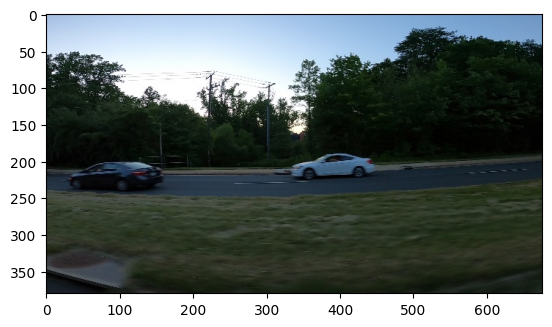

In [ ]:
plt.imshow(image_array)

In [ ]:
results = model.predict(image_array)

In [2]:
results = model.predict(source='/content/data/testing_images', save=True)

image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 1 car, 64.2ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 12.1ms
image 3/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 12.1ms
image 4/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 12.1ms
image 5/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 12.1ms
image 6/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 12.1ms
image 7/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 12.1ms
image 8/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 12.1ms
image 9/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25260.jpg

(-0.5, 1188.5, 1000.5, -0.5)

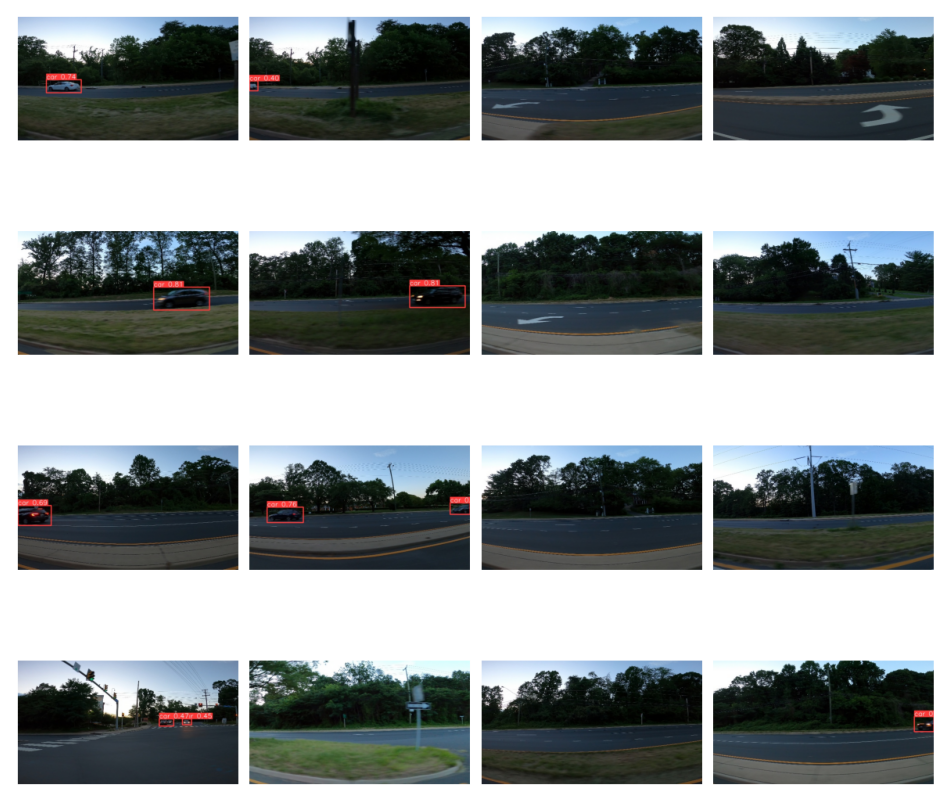

In [9]:
predictions = glob.glob(os.path.join('/content/', 'runs/detect/predict', '*'))
rows, columns = 4, 4
total_images = rows * columns
num_images = min(total_images, len(predictions))
random_indices = np.random.choice(len(predictions), num_images, replace=False)
fig, axes = plt.subplots(rows, columns, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < num_images:
        idx = random_indices[i]
        image_path = predictions[idx]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()